2.2 使用sklearn构建完整的分类项目

(1) 收集数据集并选择合适的特征：在数据集上我们使用我们比较熟悉的IRIS鸢尾花数据集。


In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target
feature = iris.feature_names
data = pd.DataFrame(X,columns=feature)
data['target'] = y
data.head()
data.head(100)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1
96,5.7,2.9,4.2,1.3,1
97,6.2,2.9,4.3,1.3,1
98,5.1,2.5,3.0,1.1,1


各个特征的相关解释：
   - sepal length (cm)：花萼长度(厘米)
   - sepal width (cm)：花萼宽度(厘米)
   - petal length (cm)：花瓣长度(厘米)
   - petal width (cm)：花瓣宽度(厘米)

(2) 选择度量模型性能的指标：                                    
度量分类模型的指标和回归的指标有很大的差异，首先是因为分类问题本身的因变量是离散变量，因此像定义回归的指标那样，单单衡量预测值和因变量的相似度可能行不通。其次，在分类任务中，我们对于每个类别犯错的代价不尽相同，例如：我们将癌症患者错误预测为无癌症和无癌症患者错误预测为癌症患者，在医院和个人的代价都是不同的，前者会使得患者无法得到及时的救治而耽搁了最佳治疗时间甚至付出生命的代价，而后者只需要在后续的治疗过程中继续取证就好了，因此我们很不希望出现前者，当我们发生了前者这样的错误的时候会认为建立的模型是很差的。为了解决这些问题，我们必须将各种情况分开讨论，然后给出评价指标。             
   - 真阳性TP：预测值和真实值都为正例；                        
   - 真阴性TN：预测值与真实值都为正例；                     
   - 假阳性FP：预测值为正，实际值为负；
   - 假阴性FN：预测值为负，实际值为正；                      
   ![jupyter](./1.22.png)                                       
分类模型的指标：                    
   - 准确率：分类正确的样本数占总样本的比例，即：$ACC = \frac{TP+TN}{FP+FN+TP+TN}$.                                
   - 精度：预测为正且分类正确的样本占预测值为正的比例，即：$PRE = \frac{TP}{TP+FP}$.                     
   - 召回率：预测为正且分类正确的样本占类别为正的比例，即：$REC =  \frac{TP}{TP+FN}$.                     
   - F1值：综合衡量精度和召回率，即：$F1 = 2\frac{PRE\times REC}{PRE + REC}$.                                     
   - ROC曲线：以假阳率为横轴，真阳率为纵轴画出来的曲线，曲线下方面积越大越好。                                                          
https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics                                                     
在本次小案例中，我们使用ROC曲线作为最终评价指标。

(3) 选择具体的模型并进行训练                              
   - **逻辑回归logistic regression：**                      
   说到分类问题与回归问题的区别，在于回归问题与分类问题需要预测的因变量不一样。在回归问题中，因变量是连续性变量，我们需要预测$E(Y|X)$是一个连续的实数，但是在分类问题中，我们往往是通过已知X的信息预测Y的类别，往往是一个离散集合中的某个元素。如：是否患癌症，图片是猫还是狗等。一个很自然的想法是能否用线性回归去处理分类问题，答案是可以但不好！先来看看线性回归处理分类问题会出现什么弊端，我们仔细来看这个线性回归的例子，${default = \beta_0 + \beta_1 Balance + \beta_2 Income}$，只要输入Balance 和 Income 以及default的数据就能用最小二乘法估计出${\beta_0,\beta_1}$,设定预测的default>0.5就是违约反之不违约，感觉很完美的样子，但事实真的是这样吗？假设我们需要用某个人的债务(Balance)和收入(Income)去预测是否会信用卡违约(default)：       
      - 我们假设有一个穷人Lisa,他的Balance和Income都很小，那么有可能会导致default的值为负数，那么这个负数代表什么意义呢？显然是没有任何意义的。                
      ![jupyter](./1.23.png)                            
      - 当我们的分类变量是多类的时候，以0.5为界限划分分类就不可用了，那么我们应该怎么找到一个界限衡量多分类呢？                              
   基于以上问题，现在大家是否还觉得线性回归模型作为一个分类模型是否足够优秀呢？其实，为了解决以上的问题（1）我们来想想能不能将线性回归的结果default转化为区间[0:1]上，让default转变成一个违约的概率呢？下面我们来解决这个问题吧。                              
   在推导逻辑回归之前，我们先来认识下一组函数，这组函数具有神奇的作用，可以将是实数轴上的数转换为[0:1]区间上的概率。
  首先，我们假设我们的线性回归模型为 ${Y=\beta_0+\beta_1 X}$，那么这个函数是如何将线性回归的结果转化为概率呢？这个函数就是logistic 函数，具体的形式为   ${p(X) = \dfrac{e^{\beta_0 + \beta_1X}}{1+e^{\beta_0 + \beta_1X}}}$，他的函数图像如下图：（左边是线性回归，右边是逻辑函数）                             
  ![jupyter](./1.24.png)                                   
  因此，我们假设逻辑回归模型为：$p(y = 1|x) = \frac{1}{1+e^{-w^Tx}}$ .                              
  下面我们来具体推导下逻辑回归模型：                          
  假设数据Data$\{(x_i,y_i) \},\;\;i = 1,2,...,N,\;\;x_i \in R^p,y_i \in \{0,1 \}$，设$p_1 = p(y=1|x) = \sigma(w^T) = \frac{1}{1+e^{-w^Tx}}$。因为y只可能取0或者1，因此假设数据服从0-1分布，也叫伯努力分布，即：当y=1时，$p(y|x)=p_1$，当y=0时，$p(y|x)=1-p_1$，可以写成$p(y|x) = p_1^y(1-p_1)^{1-y}$，可以带入y=0和y=1进去验证，结果和前面的结论一模一样。                    
  我们使用极大似然估计MLE，即：                         
  $$
  \hat{w} = argmax_w\;\;log\;P(Y|X) = argmax_x\;\;log\;\prod_{i=1}^N P(y_i|x_i) = argmax_w \sum\limits_{i=1}^{N} log\;P(y_i|x_i)\\
  \;\;\; = argmax_w \sum\limits_{i=1}^{N}(y_ilog\;p_1 + (1-y_i)log(1-p_1)) \\ 
  记：L(w) = \sum\limits_{i=1}^{N}(y_ilog\;p_1 + (1-y_i)log(1-p_1))\\
 \;\;\; \frac{\partial L}{\partial w_k} = \sum\limits_{i=1}^{N} y_i\frac{1}{p_1}\frac{\partial p_1}{\partial z}\frac{\partial z}{\partial w_k} + (1-y_i)\frac{1}{1-p_1}(-\frac{\partial p_1}{\partial z}\frac{\partial z}{\partial w_k})\\
  \;\;\;=\sum\limits_{i=1}^{N}y_i\frac{1}{\sigma(z)}(\sigma(z_i)-\sigma(z_i)^2)x_i + (1-y_i)\frac{1}{1-\sigma(z_i)}[-(\sigma(z_i)-\sigma(z_i)^2)x_i]\\
  \;\;\; =\sum\limits_{i=1}^{N}[(y_i-y_i\sigma(z_i))x_i + (1-y_i)(-\sigma(z_i))x_i]\\
  \;\;\; = \sum\limits_{i=1}^{N}y_ix_i-\sigma(z_i)x_i = \sum\limits_{i=1}^{N}(y_i-\sigma(z_i))x_i
  $$                 
  因此，$\frac{\partial L}{\partial w_k} = \sum\limits_{i=1}^{N}(y_i-\sigma(z_i))x_i$，由于这里涉及的函数不像线性回归一样能简单求出解析解，因此我们使用迭代的优化算法：梯度下降法，即：                       
  $w_k^{(t+1)}\leftarrow w_k^{(t)} - \eta \sum\limits_{i=1}^{N}(y_i-\sigma(z_i))x_i^{(k)},\;\;\;其中，x_i^{(k)}为第i个样本第k个特征$                                 
  如果想了解关于梯度下降法等无约束算法的具体细节，可以参照笔者写的另外两篇知乎博客：                          
  最优化理论之无约束优化基本结构及其python应用：https://zhuanlan.zhihu.com/p/163405865                                                   
  最优化理论之负梯度方法与Newton型方法：https://zhuanlan.zhihu.com/p/165914126                                              
  对于问题(2),我们值得注意的是，逻辑回归在实际中不太用于多分类问题，因为实际效果不是很好，所以我们可以借助其他模型来解决这个问题，那让我们来解决这个遗留下来的问题吧。                                
 

In [2]:
#  逻辑回归
'''
penalty       {‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’正则化方式
dual      bool, default=False   是否使用对偶形式，当n_samples> n_features时，默认dual = False。   
C        float, default=1.0      
solver       {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’     
l1_ratio         float, default=None           
'''
from sklearn.linear_model import LogisticRegression
log_iris = LogisticRegression()
log_iris.fit(X,y)
log_iris.score(X,y)

/home/googler/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9733333333333334

In [7]:
# 线性判别分析
'''
参数：
solver:{'svd'，'lsqr'，'eigen'}，默认='svd'
solver的使用，可能的值：
'svd'：奇异值分解（默认）。不计算协方差矩阵，因此建议将此求解器用于具有大量特征的数据。

'lsqr'：最小二乘解，可以与收缩结合使用。

'eigen'：特征值分解，可以与收缩结合使用。
'''
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_iris = LinearDiscriminantAnalysis()
lda_iris.fit(X,y)
lda_iris.score(X,y)
   

0.98

In [8]:
# 朴素贝叶斯             
from sklearn.naive_bayes import GaussianNB
NB_iris = GaussianNB()
NB_iris.fit(X, y)
NB_iris.score(X,y)

0.96

   - 决策树 ：                     
   与前面内容所讲的决策树回归大致是一样的，只是在回归问题中，选择分割点的标准是均方误差，但是在分类问题中，由于因变量是类别变量而不是连续变量，因此用均方误差显然不合适。那问题是用什么作为选择分割点的标准呢？我们先来分析具体的问题：                         
   在回归树中，对一个给定的观测值，因变量的预测值取它所属的终端结点内训练集的平均因变量。与之相对应，对于分类树来说，给定一个观测值，因变量的预测值为它所属的终端结点内训练集的**最常出现的类**。分类树的构造过程与回归树也很类似，与回归树一样，分类树也是采用递归二叉分裂。但是在分类树中，均方误差无法作为确定分裂节点的准则，一个很自然的替代指标是分类错误率。分类错误率就是：此区域内的训练集中非常见类所占的类别，即：                                   
   $$
   E = 1-max_k(\hat{p}_{mk})
   $$                       
   上式中的$\hat{p}_{mk}$代表第m个区域的训练集中第k类所占的比例。但是在大量的事实证明：分类错误率在构建决策树时不够敏感，一般在实际中用如下两个指标代替：             
   (1) 基尼系数：                   
   $$
   G = \sum\limits_{k=1}^{K} \hat{p}_{mk}(1-\hat{p}_{mk})
   $$             
   在基尼系数的定义中，我们发现这个指标衡量的是K个类别的总方差。不难发现，如果所有的$\hat{p}_{mk}$的取值都接近0或者1，基尼系数会很小。因此基尼系数被视为衡量结点纯度的指标----如果他的取值小，那就意味着某个节点包含的观测值几乎来自同一个类别。                         
   由基尼系数作为指标得到的分类树叫做：CART。                        
   (2) 交叉熵：                       
   可以替代基尼系数的指标是交叉熵，定义如下：                           
   $$
   D = -\sum\limits_{k=1}^{K} \hat{p}_{mk}log\;\hat{p}_{mk}
   $$                     
   显然，如果所有的$\hat{p}_{mk}$都接近于0或者1，那么交叉熵就会接近0。因此，和基尼系数一样，如果第m个结点的纯度越高，则交叉熵越小。事实证明，基尼系数和交叉熵在数值上时很接近的。                   
   
   ![jupyter](./1.27.png)                                            
   决策树分类算法的完整步骤：                          
      a.  选择最优切分特征j以及该特征上的最优点s：                
      遍历特征j以及固定j后遍历切分点s，选择使得基尼系数或者交叉熵最小的(j,s)                                                   
       b. 按照(j,s)分裂特征空间，每个区域内的类别为该区域内样本比例最多的类别。                           
       c. 继续调用步骤1，2直到满足停止条件，就是每个区域的样本数小于等于5。        
       d. 将特征空间划分为J个不同的区域，生成分类树。                 
   

In [42]:
# 使用决策树算法对iris分类：
'''
criterion:{“gini”, “entropy”}, default=”gini”
max_depth:树的最大深度。
min_samples_split:拆分内部节点所需的最少样本数
min_samples_leaf :在叶节点处需要的最小样本数。

'''
from sklearn.tree import DecisionTreeClassifier
tree_iris = DecisionTreeClassifier(min_samples_leaf=5)
tree_iris.fit(X,y)
tree_iris.score(X,y)

0.9733333333333334

gini


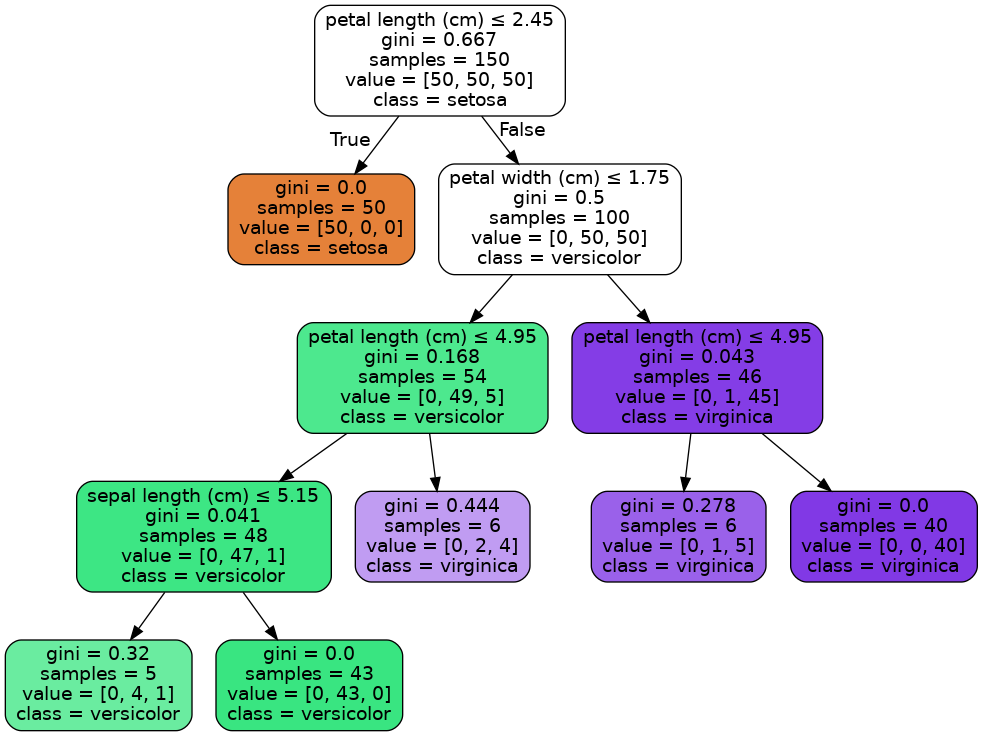

In [43]:
print(tree_iris.criterion)
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import display, Image
dot_data = export_graphviz(tree_iris,out_file=None,feature_names=iris.feature_names,class_names=iris.target_names,filled=True,rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('iris.png')
display(Image(graph.create_png()))

决策树是一种从无次序、无规则的样本数据集中推理出决策树表示形式的分类规则方法。采用自上向下的递归方式，在决策树的内部节点进行属性值的比较，并根据不同属性值判断从该节点向下分，在决策树的叶结点得到结论。因此，从根节点到叶节点的一条路径就对应一条规则，整棵决策树就对应着一组表达式规则。比较典型的决策树算法是由Breiman于1984 年提出的分类回归树(CART,Classification And Regression Tree简称为CART分类树)，并不断得到改进，现已在统计和Regression Trees，数据挖掘领域中普遍使用。它提供了一种非参数判别多数据层之间的统计关系，通过构建二叉树达到预测目的，采用一种二分递归分割的技术，将当前的样本集分为两个子样本集，使得生成的决策树的每个非叶子节点都有两个分支，其核心就是通过对由测试变量和目标变量构成的训练数据集的循环二分形成二叉树形式的决策树结构。CART分类树包含两个基本思想：第一是将练样本进行递归地划分自变量空间进行建树的想法；第二是用验证数据进行剪枝。

决策树像一棵倒长的树(当然也可以横着放)，变量年龄所在的节点称为根节点(root node)，而底部的四个节点称为叶节点(leaf node)或终节点(terminal node)。这个树也称为分类树(classification tree)，因为其目的是要把一个观测划分为“高风险“或“低风险”每个叶节点都是因变量的取值，而除了叶节点外的其他节点都是自变量。对于这个决策树，只要输人关于某司机的这几个变量的值，就立刻得到该司机相关的风险分类，
还有一种决策树是回归树(regression tree)，其根节点为连续的因变量在这个分叉上的平均取值，分类树和回归树合起来也叫做CART(Classification And Regression Tree)，上面的描述性决策树是二分的( binary split)，即每个非叶节点(non-leaf node)刚好有两个叉。决策树也可有多分叉的(multi-way split) 。决策树的节点上的变量可能是各种形式的(连续、离散、有序、分类变量等)，一个变量也可以重复出现在不同的节点，一个节点前面的节点称为其父节点(母节点或父母节点，parent node)，而该节点为前面节点的子节点( 女节点或子女节点，child node)，并列的节点也叫兄弟节点(姊妹节点，sibling node)。上面的例子是一棵现成的树，它不是随便画的，而是根据数据做出来的。
和经典回归不同，决策树不需要对总体进行分布的假定，而且，决策树对于预测很容易解释，这是其优点，此外，决策树很容易计算，但有必要设定不使其过分生长的停止规则或者修剪方法，决策树的一个缺点是每次分叉只和前一次分叉有关，而且并不考虑对以后的影响。因此，每个节点都依赖于前面的节点。如果开始的划分不同，结果也可能很不一样，目前有些人在研究分叉时考虑未来，但由于可能导致强度很大的计算，还没有见之于实际应用阶段 

In [40]:
# 使用决策树算法对iris分类：
'''
criterion:{“gini”, “entropy”}, default=”gini”
max_depth:树的最大深度。
min_samples_split:拆分内部节点所需的最少样本数
min_samples_leaf :在叶节点处需要的最小样本数。

'''
from sklearn.tree import DecisionTreeClassifier
tree_iris = DecisionTreeClassifier(criterion="entropy", min_samples_leaf=5)
tree_iris.fit(X,y)
tree_iris.score(X,y)

0.9733333333333334

entropy


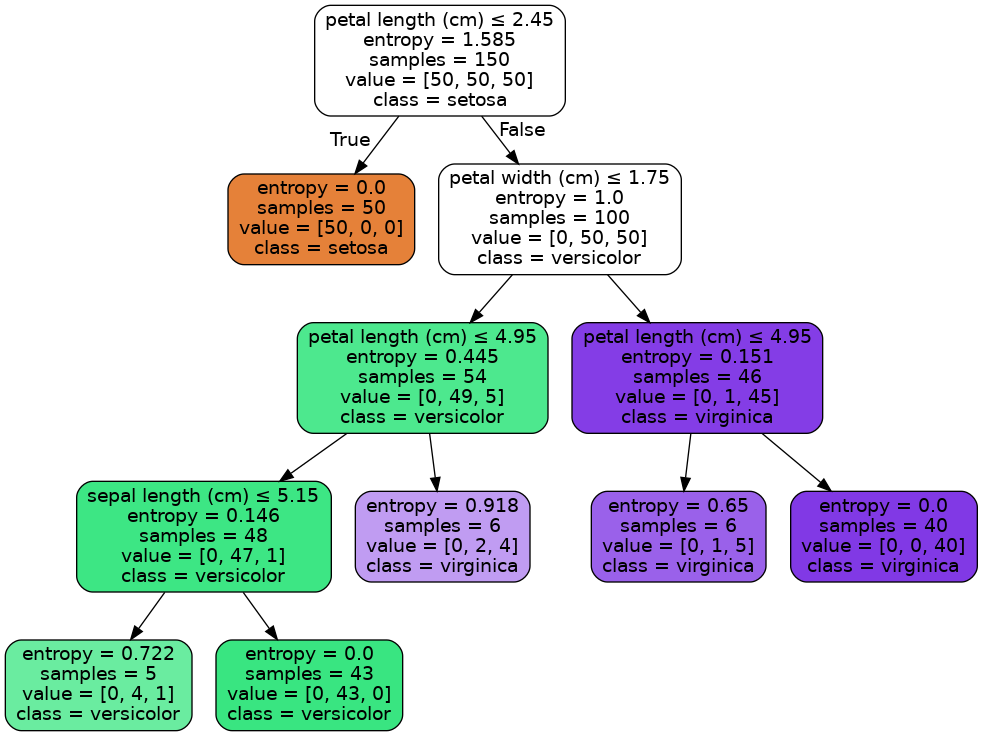

In [41]:
print(tree_iris.criterion)
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import display, Image
dot_data = export_graphviz(tree_iris,out_file=None,feature_names=iris.feature_names,class_names=iris.target_names,filled=True,rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('iris_entropy.png')
display(Image(graph.create_png()))

# 支持向量机（support vector machines）
是一种二分类模型，它的目的是寻找一个超平面来对样本进行分割，分割的原则是间隔最大化，最终转化为一个凸二次规划问题来求解。由简至繁的模型包括：当训练样本线性可分时，通过硬间隔最大化，学习一个线性可分支持向量机；
    当训练样本近似线性可分时，通过软间隔最大化，学习一个线性支持向量机；
    当训练样本线性不可分时，通过核技巧和软间隔最大化，学习一个非线性支持向量机；
![jupyter](./svm.png) 
间隔最大化和支持向量
如果一个线性函数能够将样本分开，称这些数据样本是线性可分的。那么什么是线性函数呢？其实很简单，在二维空间中就是一条直线，在三维空间中就是一个平面，以此类推，如果不考虑空间维数，这样的线性函数统称为超平面。我们看一个简单的二维空间的例子，O代表正类，X代表负类，样本是线性可分的，但是很显然不只有这一条直线可以将样本分开，而是有无数条，我们所说的线性可分支持向量机就对应着能将数据正确划分并且间隔最大的直线。
![jupyter](./1.28.png) 

非线性支持向量机：                     
   在刚刚的讨论中，我们都是着重讨论了线性支持向量机是如何工作的，但是在现实生活中，我们很难碰到线性可分的数据集，如：             
   ![jupyter](./1.29.png)                         
   那我们应该如何处理非线性问题呢？答案就是将数据投影至更加高的维度！                    
   ![jupyter](./1.30.png)                     
   上图中，在一维数据做不到线性可分，我们将数据投影至二维平面就可以成功线性可分。那么，我们来详细探讨下这其中的奥妙：                        
   
   $$
   \begin{array}{l}
   \Phi: \mathcal{X} \mapsto \hat{\mathcal{X}}=\Phi(\mathbf{x}) \\
   \Phi\left(\left[x_{i 1}, x_{i 2}\right]\right)=\left[x_{i 1}, x_{i 2}, x_{i 1} x_{i 2}, x_{i 1}^{2}, x_{i 2}^{2}\right]
   \end{array}
   $$                      
   如果我们使用上面公式的形式将低维数据拓展至高维数据，则必须面临一个很大的问题，那就是：维度爆炸导致的计算量太大的问题。假如是一个2维特征的数据，我们可以将其映射到5维来做特征的内积，如果原始空间是三维，可以映射到到19维空间，似乎还可以处理。但是如果我们的低维特征是100个维度，1000个维度呢？那么我们要将其映射到超级高的维度来计算特征的内积。这时候映射成的高维维度是爆炸性增长的，这个计算量实在是太大了，而且如果遇到无穷维的情况，就根本无从计算了。能不能呢个避免这个问题呢？核函数隆重登场：                       
   回顾线性可分SVM的优化目标函数：                  
   $$
   \underbrace{ min }_{\alpha}  \frac{1}{2}\sum\limits_{i=1,j=1}^{m}\alpha_i\alpha_jy_iy_jx_i \bullet x_j - \sum\limits_{i=1}^{m}\alpha_i\\
   s.t. \; \sum\limits_{i=1}^{m}\alpha_iy_i = 0\\
   0 \leq \alpha_i \leq C
   $$                  
   注意到上式低维特征仅仅以内积$x_i \bullet x_j$ 的形式出现，如果我们定义一个低维特征空间到高维特征空间的映射$\phi$，将所有特征映射到一个更高的维度，让数据线性可分，我们就可以继续按前两篇的方法来优化目标函数，求出分离超平面和分类决策函数了。也就是说现在的SVM的优化目标函数变成：                         
   $$
   \begin{array}{c}
   \underbrace{\min }_{\alpha} \frac{1}{2} \sum_{i=1, j=1}^{m} \alpha_{i} \alpha_{j} y_{i} y_{j} \phi\left(x_{i}\right) \bullet \phi\left(x_{j}\right)-\sum_{i=1}^{m} \alpha_{i} \\
   \text { s. } t . \sum_{i=1}^{m} \alpha_{i} y_{i}=0 \\
   0 \leq \alpha_{i} \leq C
   \end{array}
   $$                    
   可以看到，和线性可分SVM的优化目标函数的区别仅仅是将内积$x_i \bullet x_j$替换为$\phi(x_i) \bullet \phi(x_j)$。我们要将其映射到超级高的维度来计算特征的内积。这时候映射成的高维维度是爆炸性增长的，这个计算量实在是太大了，而且如果遇到无穷维的情况，就根本无从计算了。下面引入核函数：               
   假设$\phi$是一个从低维的输入空间$\chi$（欧式空间的子集或者离散集合）到高维的希尔伯特空间的$\mathcal{H}$映射。那么如果存在函数$K(x,z)$，对于任意$x, z \in \chi$，都有：                    
   $$
   K(x, z) = \phi(x) \bullet \phi(z)
   $$                       
   那么我们就称$K(x, z)$为核函数。                   
   仔细发现，$K(x, z)$的计算是在低维特征空间来计算的，它避免了在刚才我们提到了在高维维度空间计算内积的恐怖计算量。也就是说，我们可以好好享受在高维特征空间线性可分的利益，却避免了高维特征空间恐怖的内积计算量。下面介绍几种常用的核函数：                     
   (1)  多项式核函数：                   
   多项式核函数（Polynomial Kernel）是线性不可分SVM常用的核函数之一，表达式为：                         
   $$
   K\left(\mathbf{x}_{i}, \mathbf{x}_{j}\right)=\left(\left\langle\mathbf{x}_{i}, \mathbf{x}_{j}\right\rangle+c\right)^{d}
   $$             
   C用来控制低阶项的强度，C=0,d=1代表无核函数。                       
   (2) 高斯核函数：                                                   
   高斯核函数（Gaussian Kernel），在SVM中也称为径向基核函数（Radial Basis Function,RBF），它是非线性分类SVM最主流的核函数。libsvm默认的核函数就是它。表达式为：                             
   $$
   K\left(\mathbf{x}_{i}, \mathbf{x}_{j}\right)=\exp \left(-\frac{\left\|\mathbf{x}_{i}-\mathbf{x}_{j}\right\|_{2}^{2}}{2 \sigma^{2}}\right)
   $$                              
   使用高斯核函数之前需要将特征标准化，因此这里衡量的是样本之间的相似度。                    
   (3) Sigmoid核函数：                    
   Sigmoid核函数（Sigmoid Kernel）也是线性不可分SVM常用的核函数之一，表达式为：               
   $$
   K\left(\mathbf{x}_{i}, \mathbf{x}_{j}\right)=\tanh \left(\alpha \mathbf{x}_{i}^{\top} \mathbf{x}_{j}+c\right)
   $$                        
   此时的SVM相当于没有隐藏层的简单神经网络。                     
   (4) 余弦相似度核：                  
   常用于衡量两段文字的余弦相似度，表达式为：                    
   $$
   K\left(\mathbf{x}_{i}, \mathbf{x}_{j}\right)=\frac{\mathbf{x}_{i}^{\top} \mathbf{x}_{j}}{\left\|\mathbf{x}_{i}\right\|\left\|\mathbf{x}_{j}\right\|}
   $$
   

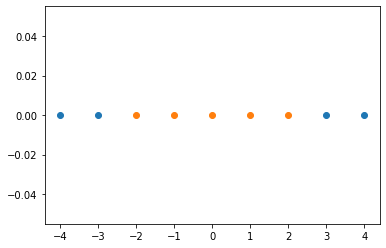

In [44]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-4, 5, 1)
y = np.array((x >= -2) & (x <= 2), dtype='int')

plt.scatter(x[y==0], [0]*len(x[y==0]))
plt.scatter(x[y==1], [0]*len(x[y==1]))
plt.show()

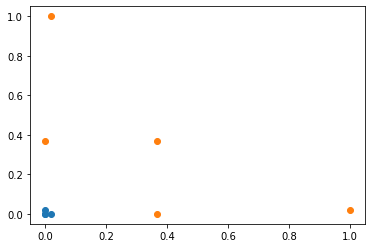

In [45]:
import numpy as np
def gaussian(x, l):
    # 此处直接将超参数 γ 设定为 1.0；
    # 此处 x 表示一维的样本，也就是一个具体的值，l 相应的也是一个具体的数，因为 l 和 x 一样，从特征空间中选定；
    gamma = 1.0
    # 此处因为 x 和 l 都只是一个数，不需要再计算模，可以直接平方；
    return np.exp(-gamma * (x-l)**2)

# 设定地标 l1、l2 为 -1和1
l1, l2 = -1, 1
x_new = np.empty((len(x), 2))

for i, data in enumerate(x):
    x_new[i, 0] = gaussian(data, l1)
    x_new[i, 1] = gaussian(data, l2)

plt.scatter(x_new[y==0, 0], x_new[y==0, 1])
plt.scatter(x_new[y==1, 0], x_new[y==1, 1])
plt.show()

In [48]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
# C:正则化参数。正则化的强度与C成反比。必须严格为正。惩罚是平方的l2惩罚。
# kernel:{'linear'，'poly'，'rbf'，'sigmoid'，'precomputed'}，默认='rbf'
# degree:多项式和的阶数
# gamma:“ rbf”，“ poly”和“ Sigmoid”的内核系数。
# shrinking:是否软间隔分类，默认true
import numpy as np
import pandas as pd
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target
feature = iris.feature_names
data = pd.DataFrame(X,columns=feature)
data['target'] = y

svc_iris = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svc_iris.fit(X, y)
svc_iris.score(X,y)

0.9733333333333334